$$ \LaTeX \text{ command declarations here.}
\newcommand{\N}{\mathcal{N}}
\newcommand{\R}{\mathbb{R}}
\renewcommand{\vec}[1]{\mathbf{#1}}
\newcommand{\norm}[1]{\|#1\|_2}
\newcommand{\d}{\mathop{}\!\mathrm{d}}
\newcommand{\qed}{\qquad \mathbf{Q.E.D.}}
\newcommand{\vx}{\mathbf{x}}
\newcommand{\vy}{\mathbf{y}}
\newcommand{\vt}{\mathbf{t}}
\newcommand{\vb}{\mathbf{b}}
\newcommand{\vw}{\mathbf{w}}
\newcommand{\vm}{\mathbf{m}}
\newcommand{\I}{\mathbb{I}}
\newcommand{\th}{\text{th}}
$$

In [2]:
from __future__ import division

# plotting
%matplotlib inline
from matplotlib import pyplot as plt;
from matplotlib import colors
import matplotlib as mpl;
from mpl_toolkits.mplot3d import Axes3D
if "bmh" in plt.style.available: plt.style.use("bmh");
    
# matplotlib objects
from matplotlib import mlab;
from matplotlib import gridspec;

# scientific
import numpy as np;
import scipy as scp;
from scipy import linalg
import scipy.stats;

# table display
import pandas as pd
from IPython.display import display

# python
import random;

# warnings
import warnings
warnings.filterwarnings("ignore")

# import this lecture's function
from Lec08 import *

# rise config
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
              'theme': 'simple',
              'start_slideshow_at': 'selected',
              'transition':'fade',
              'scroll': False
});

# EECS 545:  Machine Learning
## Lecture 08:  Naive Bayes, GDA and LDA

* Instructor:  **Jacob Abernethy**
* Date:  Monday, February 1, 2016

*Lecture Exposition Credit:*  Benjamin Bray, Valli Chockalingam

## Outline
- Probabilistic Models
    - Generative Models
    - Discriminative Models
- Naive Bayes Classifiers
    - Independence Assumption
    - MLE and MAP Parameter Estimates
- Gaussian Discriminant Analysis
    - Quadratic Discriminant Analysis
    - Linear Discriminant Analysis
- Fisher's Linear Discriminant

## Reading List

- Required:
    - **[PRML]**, §4.2: Probabilistic Generative Models
    - **[PRML]**, §4.3: Probabilistic Discriminative Models
    - **[PRML]**, §4.1: Discriminant Functions
    - **[MLAPP]**, §3.5: Naive Bayes Classifiers
    - **[MLAPP]**, §4.1: Gaussian Models
    - **[MLAPP]**, §4.2: Gaussian Discriminant Analysis

> In this lecture, we will first talk about the some concepts of probabilistic models for classifiers, especially generative model and discriminant model. And we will introduce Naive Bayes classifier, which assumes independent features give label and is a classical classifier commonly used in spam email classification. The remaining two classifier we will talk about is Gaussian Discriminant Analysis and Fisher's Linear Discriminant. Gaussian Discriminant Analysis has quadratic boundary when different classes have different covariance matrix and has linear boundary when the covariance matrices are shared. 

## Probablistic Models

### Probablistic Models: Generative Models

- **Generative model** learns *class-conditional * $P(X | Y)$ and label densities $P(Y)$ from training data

- Perform prediction using the **posterior** via Bayes' Rule. For some new data $\vx^{new}$
    $$
    \begin{align}
    y 
    & = \underset{k \in \{1, \dots, K\}}{\arg \max} P(Y=k | X = \vx^{new} ) \\
    & = \underset{k \in \{1, \dots, K\}}{\arg \max} \frac{P(X = \vx^{new} | Y=k)P(Y=k)}{P(X = \vx^{new})} \\
    & = \boxed{\underset{k \in \{1, \dots, K\}}{\arg \max} P(X = \vx^{new} | Y=k)P(Y=k)}
    \end{align}
    $$
    of which the last equality holds because the denominator $P(X = \vx^{new})$ is independent of $k$.

- Basic idea of prediction is picking the label with largest posterior probability given its features $\vx^{new}$.

- Why is this model called **generative**?
    - We learned *class-conditional probabiliy* $P(X | Y)$ from training data.
    - $P(X | Y)$ is distribution of data $X$ given label $Y$
    - So given some label $Y$, could **generate**/sample new data $X$ from $P(X | Y)$.

- The *prior* $P(Y)$ encodes beliefs about popularity of each label

- By comparing the synthetic data and real data, we get a sense of how good our generative model is.

### Probablistic Models: Generative Models—Examples
- Simple examples:
    - Naive Bayes (Later)
    - Gaussian Discriminant Analysis (Later)

- More abstract examples:
    - Linear Regression
    - Most Bayesian models

### Probablistic Models: Discriminative Models

- Conversely, a **discriminative model** learns posterior $P(Y | X)$ directly from training data.

- Goal: select a hypothesis to *discriminates* between class labels.

- The prediction for some new data $\vx^{new}$ is
    $$ y = \underset{k \in \{1, \dots, K\}}{\arg \max} P(Y=k | X = \vx^{new} ) \\$$

- Does not (necessarily) provide the ability to **generate** new random examples because unlike generative models, we have no idea what $P(X|Y)$ is.

- Allows us to focus purely on the classification task

- We will discuss the pros and cons of each model later.

### Probablistic Models: Discriminative Models—Property

- The discriminative approach will typically 
    - have fewer parameters to estimate
    - make fewer assumptions about data distribution
        - Linear (logistic regression) vs quadratic (GDA) in the input dimension
    - make fewer generative assumptions about the data
        - However, reconstruction features from labels may require prior knowledge

## Naive Bayes Classifiers

> Follows the approach taken by **[MLAPP]**

### Naive Bayes:  Problem

- We will use **Naive Bayes** to solve the following classification problem:
    - **Categorical** feature vector $\vx = (x_1, x_2, \dots, x_D)$ with length $D$
        - Each feature $x_d \in \{1, \dots ,M \}$, $\forall d = 1, \dots, D$
    - Predict discrete class label $y \in \{1, 2, \dots, C \}$

- For example, in **Spam Mail Classification**,
    - Predict whether an email is `SPAM` ($y=1$) or `HAM` ($y=0$)
    - Use words / metadata in the email as features
    - For simplicity, we can use **bag-of-words** features,
        - Assume fixed vocabulary $V$ of size $|V| = D$
        - Feature $x_d$, for $d \in \{1, 2, \dots, D \}$, indicates the existence of $d\text{th}$ word in the email
        - Eg. $x_d = 1$ if $d\text{th}$ word is in the email; $x_d = 0$ otherwise
        - In this case $M=2$

### Naive Bayes:  Independence Assumption and Full model

- The essence of Naive Bayes is the **conditionally independence assumption**
    $$
    P(\vx | y = c) = \prod_{d=1}^D P(x_d | y=c)
    $$
    i.e., given the label, all features are independent.
    
- The **full generative** model of Naive Bayes is:
    $$
    \begin{align}
    y       &\sim \mathrm{Categorical}(\pi) \\
    x_d | y=c &\sim \mathrm{Categorical}(\theta_{cd}) \quad \forall\, d = 1,\dots,D
    \end{align}
    $$
    with parameters:
    - **Class priors** $\pi = (\pi_1, \dots, \pi_C) \in \Delta^C$, 
        - i.e. $P(y = c) = \pi_c$, $\forall c = 1,\dots,C $
        - $\Delta^C$ is C-**simplex**. $\pi \in \Delta^C$ is saying that $\sum_{c=1}^C \pi_c = 1$ and $\pi_c \geq 0, \forall c=1,\dots,C$
    - **Class-conditional probabilities** $\theta_{cd} = (\theta_{cd1},  \dots, \theta_{cdM}) \in \Delta^M$
        - i.e. $P(x_d = m| y = c) = \theta_{cdm}, \forall d = 1,\dots,D, m = 1, \dots, M, c = 1, \dots, C$

- Parameter $\pi$ and $\theta$ are learned from training data.

>**Remark**
> - **NOTE** in definition and derivation of this lecture, we assume a more general case $x_d \in \{1, \dots ,M \}$ of which $M>2$. But in spam email classification and the derivation in textbook, binary feature, i.e. $M=2$, is used. So don't get confused!

> - When $M=2$, $x_d | y=c$ is also Bernoulli distribution.

### Naive Bayes: Prediction

- Given the independence assumption and full model, for some \text{new} data $\vx^{\text{new}} = (x_1^{\text{new}}, \dots, x_D^{\text{new}})$ we will classify based on
    $$
    \begin{align}
    y
    &=\underset{c \in \{1,\dots,C\}}{\arg \max} P(y=c|\vx = \vx^{\text{new}}) \\
    &=\underset{c \in \{1,\dots,C\}}{\arg \max} P(\vx = \vx^{\text{new}} | y=c) P(y=c) \\
    &=\underset{c \in \{1,\dots,C\}}{\arg \max} P(y=c) \prod \nolimits_{d=1}^{D} P(x_d = x_d^{\text{new}} | y=c) \\
    &=\boxed{\underset{c \in \{1,\dots,C\}}{\arg \max} \pi_c \prod \nolimits_{d=1}^{D} \theta_{cdx_d^{\text{new}}}} \\
    \end{align}
    $$
    
- If we assume $x_d^{\text{new}} \in \{1,\dots,M \}, \forall d = 1,\dots,D$, we could also express the above expression equivalently using **indicator function**
    $$
    y = \underset{c \in \{1,\dots,C\}}{\arg \max} \pi_c \prod \nolimits_{d=1}^{D} \prod \nolimits_{m=1}^{M} \theta_{cdm}^{\mathbb{I}(x_d^{\text{new}}=m)}
    $$
    
- So as long as we learned parameter $\pi$ and $\theta$, we could classify.

> **Remark**

> - Indicator function
    $$
    \mathbb{I}(x_d^{\text{new}}=m) = 
    \begin{cases}
    1 & \text{ if } x_d^{\text{new}}=m\\ 
    0 & \text{ otherwise}
    \end{cases}
    $$
    
> - In inner product $\prod \nolimits_{m=1}^{M} \theta_{cdm}^{\mathbb{I}(x_d^{\text{new}}=m)}$ actually only $\theta_{cdx_d^{\text{new}}}$ is multiplied and all the other multipliers are 1 due to the power of indicator function.
    
> - One thing to note is that the above classification criterion is the product of a series numbers smaller than 1 which will generate a rather small number. A better way is to take **logarithm** to transform product into summation and then compare.

### Naive Bayes:  Parameter Estimation

- **Goal:** Given training data $\mathcal{D} = \{ (\vec{x}_1, y_1), \dots, (\vec{x}_N, y_N) \}$, estimate **class-conditional probabilities** $\theta$ and **class priors** $\pi$.


- We will discuss the **MLE** and **MAP** parameter estimates.    

### Naive Bayes:  Maximum Likelihood

- The **likelihood** for a single data case $(\vec{x}_n, y_n=c)$ is
    $$
    \begin{align}
    P((\vec{x}_n, y_n) | \pi, \theta)
    &= P(y_n) \prod \nolimits_{d=1}^D P(x_{nd}|y_n) \\
    &= \prod_{c=1}^C P(y_n=c)^{\I(y_n=c)} \cdot \prod_{c=1}^D \prod_{d=1}^D \prod_{m=1}^M P(x_{nd}=m|y_n=c)^{\I(x_{nd}=m) \I(y_n=c)}\\
    &= \prod \nolimits_{c=1}^C \pi_c^{\I(y_n=c)} \cdot \prod \nolimits_{c=1}^D \prod \nolimits_{d=1}^D \prod \nolimits_{m=1}^M \theta_{cdm}^{\I(x_{nd}=m) \I(y_n=c)}\\
    \end{align}
    $$

- Therefore, the **log-likelihood** is
    $$
    \log P((\vec{x}_n, y_n) | \pi, \theta)
    = \sum_{c=1}^C \I(y_n=c) \log \pi_c + \sum_{c=1}^D \sum_{d=1}^D \sum_{m=1}^M \I(x_{nd}=m) \I(y_n=c) \log \theta_{cdm}
    $$
    
- The **log-likelihood** for all training data $\mathcal{D}$ is
    $$
    \begin{align}
    \log P(\mathcal{D}| \pi, \theta) 
    &= \log \prod \nolimits_{n=1}^N P((\vec{x}_n, y_n) | \pi, \theta) = \sum \nolimits_{n=1}^N \log P((\vec{x}_n, y_n) | \pi, \theta) \\
    &= \boxed{\sum_{n=1}^N \sum_{c=1}^C \I(y_n=c) \log \pi_c + \sum_{n=1}^N \sum_{c=1}^D \sum_{d=1}^D \sum_{m=1}^M \I(x_{nd}=m) \I(y_n=c) \log \theta_{cdm}}
    \end{align}
    $$

### Naive Bayes:  Maximum Likelihood

- The **likelihood** for a single data case $(\vec{x}_n, y_n=c)$ is
    $$
    \begin{align}
    & P((\vec{x}_n, y_n) | \pi, \theta) \\
    &= P(y_n) \prod \nolimits_{d=1}^D P(x_{nd}|y_n) \\
    &= \prod \nolimits_{c=1}^C P(y_n=c)^{\I(y_n=c)} \cdot \prod \nolimits_{c=1}^C \prod \nolimits_{d=1}^D \prod \nolimits_{m=1}^M P(x_{nd}=m|y_n=c)^{\I(x_{nd}=m) \I(y_n=c)}\\
    &= \prod \nolimits_{c=1}^C \pi_c^{\I(y_n=c)} \cdot \prod \nolimits_{c=1}^C \prod \nolimits_{d=1}^D \prod \nolimits_{m=1}^M \theta_{cdm}^{\I(x_{nd}=m) \I(y_n=c)}\\
    \end{align}
    $$

- Therefore, the **log-likelihood** is
    $$
    \begin{split}
    & \log P((\vec{x}_n, y_n) | \pi, \theta) \\
    & = \sum \nolimits_{c=1}^C \I(y_n=c) \log \pi_c + \sum \nolimits_{c=1}^C \sum \nolimits_{d=1}^D \sum \nolimits_{m=1}^M \I(x_{nd}=m) \I(y_n=c) \log \theta_{cdm}
    \end{split}
    $$
    
- The **log-likelihood** for all training data $\mathcal{D}$ is
    $$
    \begin{align}
    & \log P(\mathcal{D}| \pi, \theta)\\
    &= \log \prod \nolimits_{n=1}^N P((\vec{x}_n, y_n) | \pi, \theta) = \sum \nolimits_{n=1}^N \log P((\vec{x}_n, y_n) | \pi, \theta) \\
    &= \boxed{\sum \nolimits_{n=1}^N \sum \nolimits_{c=1}^C \I(y_n=c) \log \pi_c + \sum \nolimits_{n=1}^N \sum \nolimits_{c=1}^C \sum \nolimits_{d=1}^D \sum \nolimits_{m=1}^M \I(x_{nd}=m) \I(y_n=c) \log \theta_{cdm}}
    \end{align}
    $$

### Naive Bayes:  Maximum Likelihood

- With the constraints $\sum_{c=1}^C \pi_c=1$ and $\sum_{m=1}^M \theta_{cdm}=1$, we could maximize log-likelihood function $\log P(\mathcal{D}| \pi, \theta)$ using *Lagrange multiplier*. (Derivation is in the notes!)

- By maximizing log-likelihood function, we could have maximum likelihood estimators:
    $$
    \hat{\pi}_c = \frac{N_c}{N} \quad \hat{\theta}_{cdm} = \frac{N_{cdm}}{N_c}
    $$
    and
    $$
    \hat{\pi} = (\hat{\pi}_1, \dots,\hat{\pi}_c, \dots,\hat{\pi}_C); \hat{\theta}_{cd} = (\hat{\theta}_{cd1}, \dots,\hat{\theta}_{cdm}, \dots,\hat{\theta}_{cdM})
    $$
    - $N = $ Number of examples in $\mathcal{D}$
    - $N_c = $ Number of examples in class $c$ in $\mathcal{D}$
    - $N_{cdm} = $ Number of examples in class $c$ with $x_d = m$ in $\mathcal{D}$
    
- Intuitive Interpretation
    - The class prior $\pi$ is obtained from the density of each class $\{1, \dots, C\}$ in $\mathcal{D}$
    - The class-conditional probability $\theta_{cd}$ is obtained from the density of $x_d \in \{1,\dots,M \}$ among all examples in class $c$

> **Remark**

> - Derivation of **maximum likelihood estimator** $\hat{\pi}_c$

>     - We have the following problem
        $$
        \begin{matrix}
        \left\{
        \begin{split}
        \max \quad &\log P(\mathcal{D}| \pi, \theta) \\
        \text{s.t.}  \quad &\sum \nolimits_{c=1}^C \pi_c=1
        \end{split} \right.
        &
        \overset{\text{equivalent to}}{\Longrightarrow}
        &
        \left \{
        \begin{split}
        \max \quad & \sum \nolimits_{n=1}^N \sum \nolimits_{c=1}^C \I(y_n=c) \log \pi_c \\
        \text{s.t.} \quad &\sum \nolimits_{c=1}^C \pi_c = 1
        \end{split}
        \right.
        \end{matrix}
        $$
        We drop the second term in $\log P(\mathcal{D}| \pi, \theta)$ because it doesn't depend on $\pi_c$
>     - The lagragian is
        $$
        L(\pi, \lambda) = \sum \nolimits_{n=1}^N \sum \nolimits_{c=1}^C \I(y_n=c) \log \pi_c - \lambda \sum \nolimits_{c=1}^C \pi_c -\lambda
        $$
>     - Setting partial derivative with respect to $\pi_c$ to 0, we have
        $$
        \frac{\partial L(\pi, \lambda)}{\partial \pi_c} = 0
        \quad \Rightarrow  \quad 
        \sum \nolimits_{n=1}^N \I(y_n=c) \frac{1}{\pi_c} - \lambda = 0  
        \quad \Rightarrow  \quad 
        \pi_c = \frac{1}{\lambda} \sum \nolimits_{n=1}^N \I(y_n=c)
        $$
>     - Plug $\pi_c$ back into the constraint $\sum \nolimits_{c=1}^C \pi_c=1$, we have
        $$
        \frac{1}{\lambda} \sum \nolimits_{c=1}^C \sum \nolimits_{n=1}^N \I(y_n=c) = 1
        \quad \Rightarrow  \quad 
        \lambda = \sum \nolimits_{c=1}^C \sum \nolimits_{n=1}^N \I(y_n=c)
        $$
>     - Plug $\lambda$ into $\pi_c = \frac{1}{\lambda} \sum \nolimits_{n=1}^N \I(y_n=c)$, we have
        $$
        \hat{\pi}_c = \frac{\sum \nolimits_{n=1}^N \I(y_n=c)}{ \sum \nolimits_{n=1}^N \sum \nolimits_{c=1}^C \I(y_n=c)} = \frac{N_c}{N}
        $$
           

> - Derivation of maximum likelihood estimator $\hat{\theta}_{cdm}$

>     - With the constraint $\sum_{m=1}^M \theta_{cdm}=1$, using similar approach, we could have 
        $$
        \hat{\theta}_{cdm}
        = \frac{\sum \nolimits_{n=1}^N \I(x_{nd}=m) \I(y_n=c)}{\sum_{n=1}^N \sum_{m=1}^M \I(x_{nd}=m) \I(y_n=c)}
        = \frac{N_{cdm}}{N_c}
        $$
        
>    - Details are left as an exercise XD     

### Naive Bayes:  Sparse Features

- **Problem:** When working with text, features are **sparse**:
    - In training, we only see a *small, small* fraction of words in the vocabulary
    - Moreover, we won't see all words exhibited across all classes

- This causes overfitting!
    - What if a word (e.g. "`subject:`") occurs in every training example of both classes?
    - Then if we encounter a new email without this word, our algorithm will crash.
    - What happens if that word never appears in testing?  (*Black Swan Paradox*)

### Naive Bayes:  Priors

- **Solution:** Place Dirichlet priors on $\pi$ and $\theta_{cd}$ to *smooth out* unknowns:
    $$
    \begin{align}
    \pi       &\sim \mathrm{Dirichlet}(\alpha_1, \dots, \alpha_C) \\
    \theta_{cd}  &\sim \mathrm{Dirichlet}(\beta_{cd1}, \dots, \beta_{cdM})  & &\quad  \forall\, c=1,\dots,C; d=1, \dots D \\
    y         &\sim \mathrm{Categorical}(\pi)                     \\
    x_d | y=c &\sim \mathrm{Categorical}(\theta_{cd}) & & \quad \forall\, d = 1,\dots,D
    \end{align}
    $$

- **Dirichlet distribution** $\pi \sim \mathrm{Dirichlet}(\alpha_1, \dots, \alpha_C)$ defines the distribution of C-simplex $\pi = (\pi_1, \dots, \pi_C)$ such that
    - $\pi_1, \dots, \pi_C \geq 0$
    - $\pi_1+ \dots + \pi_C = 1$
    - PDF $f(\pi_1, \dots, \pi_C ) = \frac{1}{B(\alpha)} \prod_{c=1}^C \pi_c^{\alpha_c-1}$ of which $B(\alpha)$ is for normalization    

- When $M=2$, $\theta_{cd}$ reduces to **Beta** distribution

### Naive Bayes:  MAP Estimation

- The **MAP parameter** estimates with priors
    $$
    \pi \sim \mathrm{Dirichlet}(\alpha_1, \dots, \alpha_C) \qquad \theta_{cd} \sim \mathrm{Dirichlet}(\beta_{cd1}, \dots, \beta_{cdM})
    $$
    are
    $$
    \hat{\pi}_c = \frac{N_c+\alpha_c}{N + \sum_{c'=1}^C \alpha_{c'}} \quad \hat{\theta}_{cdm} = \frac{N_{cdm}+\beta_{cdm}}{N_c + \sum_{m'=1}^M \beta_{cdm'}}
    $$
    
- Proof is in the notes!    

- The Dirichlet $\alpha$ and $\beta_{cd}$ parameters turn out to be **pseudocounts**!  
    - We assume we've seen $\alpha_c$ examples of class $c$ beforehand
    - and $\beta_{cdm}$ examples with $x_d = m$ in class $c$.

- The choice $\alpha_c = \beta_{cdm} = 1$ is **Laplace Smoothing**

> **Remark**

> - Derivation of **MAP estimator** $\hat{\pi}_c$

>     - MAP estimator is obtained by maximizing the product of likelihood $P(\mathcal(D) | \pi, \theta) $ and prior $f(\pi_1, \dots, \pi_C )$
        $$
        \begin{split}
        \log P(\mathcal{D} | \pi, \theta) f(\pi_1, \dots, \pi_C ) 
        &= \log P(\mathcal{D} | \pi, \theta) + \log f(\pi_1, \dots, \pi_C ) \\
        &= \sum \nolimits_{n=1}^N \sum \nolimits_{c=1}^C \I(y_n=c) \log \pi_c + \sum \nolimits_{n=1}^N \sum \nolimits_{c=1}^C \sum \nolimits_{d=1}^D \sum \nolimits_{m=1}^M \I(x_{nd}=m) \I(y_n=c) \log \theta_{cdm} \\
        &+ \sum \nolimits_{c=1}^C (\alpha_c-1)\log\pi_C - \log B(\alpha)
        \end{split}
        $$

>     - We have the following problem
        $$
        \begin{matrix}
        \left\{
        \begin{split}
        \max \quad &\log P(\mathcal{D} | \pi, \theta) f(\pi_1, \dots, \pi_C ) \\
        \text{s.t.}  \quad &\sum \nolimits_{c=1}^C \pi_c=1
        \end{split} \right.
        &
        \overset{\text{equivalent to}}{\Longrightarrow}
        &
        \left \{
        \begin{split}
        \max \quad & \sum \nolimits_{c=1}^C \left(\alpha_c -1 + \sum \nolimits_{n=1}^N \I(y_n=c) \right) \log \pi_c \\
        \text{s.t.} \quad &\sum \nolimits_{c=1}^C \pi_c = 1
        \end{split}
        \right.
        \end{matrix}
        $$

>     - Recall when deriving maximum likelihood estimator, we solved the following problem
        $$
        \left \{
        \begin{split}
        \max \quad & \sum \nolimits_{n=1}^N \sum \nolimits_{c=1}^C \I(y_n=c) \log \pi_c \\
        \text{s.t.} \quad &\sum \nolimits_{c=1}^C \pi_c = 1
        \end{split}
        \right.
        \longrightarrow
        {\hat{\pi}_c}_{MLE} = \frac{\sum \nolimits_{n=1}^N \I(y_n=c)}{ \sum \nolimits_{n=1}^N \sum \nolimits_{c=1}^C \I(y_n=c)} = \frac{N_c}{N}
        $$
        
>     - So the solution of our current problem can be easily read off
        $$
        \begin{split}
        {\hat{\pi}_c}_{MAP} 
        &= \frac{\alpha_c -1 + \sum \nolimits_{n=1}^N \I(y_n=c)}{\sum \nolimits_{c'=1}^C \left(\alpha_c' -1 + \sum \nolimits_{n=1}^N \I(y_n=c) \right)} = \frac{N_c + \alpha_c -1}{N + \sum \nolimits_{c'=1}^C \left(\alpha_c' -1\right)}
        \end{split}
        $$

> - Derivation of **MAP estimator** $\hat{\theta}_{cdm}$ is left as an exercise! Approach is exactly the same as deriving $\hat{\pi}_c$.

**To Jake**, through my derivation, I have -1 term in both nominator and denominator, but in [MLAPP] as well as other online resources like 
http://disi.unitn.it/~passerini/teaching/2015-2016/MachineLearning/slides/11_naive_bayes/talk.pdf
http://www.stats.ox.ac.uk/~teh/teaching/smldmHT2014/W7slides4.pdf
https://www.cs.ubc.ca/~murphyk/Teaching/CS340-Fall06/reading/NB.pdf
they don't have the -1 term, which is really weird. Could you help check it?

### Naive Bayes:  Challenge

> How should we deal with *out-of-vocabulary* words, i.e. words in the test set that we didn't include in the vocabulary during training?

### Naive Bayes:  Is Independence Justified?

- Naive Bayes assumes features contribute *independently* to the class label.
    
    - This is the *simplest possible* generative model... and an **extreme** assumption...

- This model is *naive* because we would never expect features to be independent!

    -  We are completely ignoring correlations between variables!

- It seems not to matter that independence is often false...
    - Naive Bayes performs surprisingly well on real-world data
    - Naive Bayes is often used as a baseline

- One reason is that the model is quite simple
    - Only $O(CD)$ parameters, for $C$ classes and $D$ features
    - Hence relatively immune to overfitting
    
- There are some interesting theoretical justifications, too!

    - Zhang, 2004, "[The optimality of naive Bayes.](http://www.cs.unb.ca/profs/hzhang/publications/FLAIRS04ZhangH.pdf)"
    - Domingos & Pazzani, 1997, "[On the optimality of the simple Bayesian classifier under zero-one loss.](http://web.cs.ucdavis.edu/~vemuri/classes/ecs271/Bayesian.pdf)".

- Apparently, dependencies between variables can "cancel out"...    

## Discriminant Functions

### Discriminant Functions

- A **discriminant function** maps an input vector to one of $C$ classes.
    - Characterized by a **decision boundary**
    - We will mainly focus on **linear discriminants**

- A **linear discriminant function** $y(x) = \vw^T x + w_0$ divides two classes in feature space
    - weight vector $\vw \in \R^D$, bias $w_0 \in \R$
    - In two dimensions, this discriminant function is a line
    - In three dimensions, a plane
    - In general, a **separating hyperplane**!

- Assign $x$ to $C_1$ if $y(x) \geq 0$ and to $C_0$ otherwise.

- Recall in Lec07, we used discriminant functions in perceptron and logistic regression.
    - In perceptron, $y = \text{sign}(\vw^T \phi(\vx))$
    - In logistic regression, $y = \I(\vw^T \phi(\vx) \geq 0)$

- See **[PRML]** section 4.1 for a discussion of multiclass problems.

### Discriminant Functions: How to select weights $\vw$?

One approach: Use **least Squares** for classification by setting the target values to be 1 and 0. Choose $\vw$ that minimizes squared error

**Bad Idea:**  
- Least squares is too sensitive to outliers.  (*Why?*)

<center> <img src="images/linear-discriminant-least-squares.png"  style="width:400px;height:180px;"> </center>

### Discriminant Functions: Least Squares is Sensitive to Noise

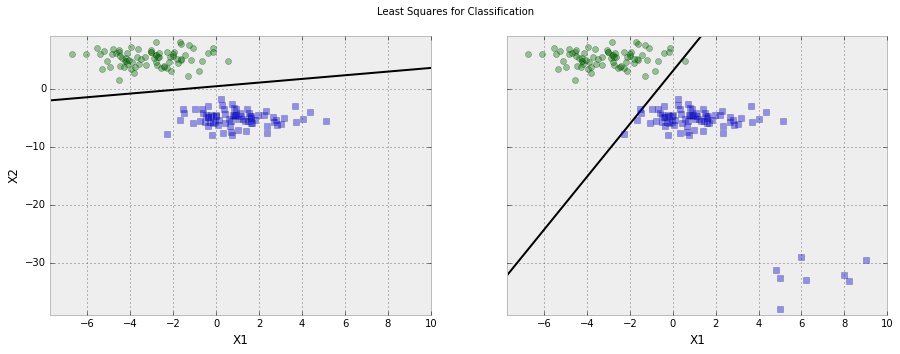

In [3]:
means = [[-3, 5], [1, -5]]; covs = [[[2, 0], [0, 2]], [[2, 0], [0, 2]]]; n = [75, 75]
outliers = [[5,-38], [9, -29.5], [8, -32.2], [6.2, -33], [4.8, -31.2], [6, -29], [8.2, -33.2], [5, -32.7]]
lin_reg_classifier(means, covs, n, outliers)

### Discriminant Functions: How to select weights $\vw$?

- **Better Idea:**  We'll cover the following models
    - Gaussian Discriminant Analysis
        - Quadratic Discriminant Analysis
        - Linear Discriminant Analysis
    - Fisher's Linear Discriminant

## Gaussian Discriminant Analysis

### Review:  Multivariate Gaussian

- A **normally distributed** random vector $\vx$ with mean $\mu \in \R^D$ and positive semi-definite covariance matrix $\Sigma \in \R^{D \times D}$ has PDF:
    $$
    \mathcal{N}(x | \mu, \Sigma) = \frac{1}{Z} \exp \left\{- \frac {1}{2} (x - \mu)^T \Sigma^{-1} (x - \mu) \right\}
    $$
    with normalization constant $Z = (2\pi) ^\frac{D}{2} |\Sigma|^ \frac{1}{2}$.  

- One-dimensional case:
    $$
    \mathcal{N}(x | \mu, \sigma^2)
    = \frac{1}{\sqrt{2\pi \sigma^2}}
    \exp\left\{ -\frac{(x - \mu)^2}{2 \sigma^2} \right\}
    $$
    
- When covariance matrix $\Sigma$ is diagonal, elements in $\vx$ are *independent* of each other. Otherwise, elements are *correlated*.

### Gaussian Discriminant Analysis:  Model

- Generative probabilistic model of Gaussian Discriminant Analysis (**GDA**)
    - Predict discrete label $y \in \{1, \dots, C \}$ from *continuous* features $\vx$
        - Recall in Naive Bayes, the features are *categorical* and *discrete*.
    - Class-conditional densities are multivariate Gaussian
    $$
    \begin{align}
    y &\sim \mathrm{Categorical}(\pi) \\
    \vx \mid y=c &\sim \mathcal{N}(\mu_c, \Sigma_c)
    \end{align}
    $$
    with per-class means $\mu_c$ and covariance matrices $\Sigma_c$
    
- GDA models **feature correlations**
    - Recall in Naive Bayes, features are **independent** given the label

- However, if all covariance matrices are diagonal, then GDA can be seen as the continuous analogue of Naive Bayes!

### Gaussian Discriminant Analysis:  Data

- Because GDA is a *generative* model, when the parameters $\pi, \mu_c$ and $\Sigma_c$ are known or learned, we can *generate* fake data!

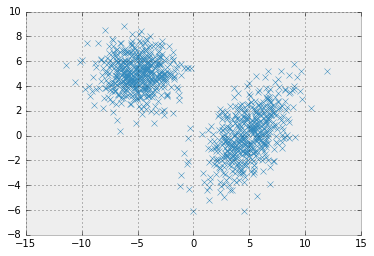

In [4]:
means = [ [-5,5], [5, 0] ]; covs = [ [[3, 0], [0, 2]], [[4, 2], [2, 4]] ]; # define gaussians
x, y = generate_gda(means, covs, 1000); plt.plot(x, y, 'x'); # generate and plot

### Gaussian Discriminant Analysis:  Classification

- Classify a feature vector $\vx$ using the **posterior mode**:

$$
\begin{align}
y
&= \underset{c}{\arg\max} \log P(y=c | \vx) = \arg\max_c \log P(\vx|y=c)P(y=c) \\
&= \underset{c}{\arg\max} \left[ \log P(y=c|\pi) + \log P(\vx|\mu_c, \Sigma_c) \right] \\
&= \underset{c}{\arg\max} \log \pi_c + \log \left[ (2\pi)^{-\frac{D}{2}} |\Sigma_c|^{-\frac12} \exp \left\{ -\frac12 (\vx-\mu_c)^T \Sigma_c^{-1} (\vx-\mu_c) \right\} \right] \\
&= \underset{c}{\arg\max} \boxed{ \log \pi_c - \frac12 \log |\Sigma_c| - \frac12 (\vx-\mu_c)^T \Sigma_c^{-1} (\vx-\mu_c) }\\
&= \underset{c}{\arg\min} \boxed{ \frac12 \log |\Sigma_c| + \frac12 (\vx-\mu_c)^T \Sigma_c^{-1} (\vx-\mu_c) - \log \pi_c}
\end{align}
$$

- The probability of $\vx$ under each class-conditional density is the distance from $x$ to the center $\mu_c$ of each class, using [**Mahalanobis distance**](https://en.wikipedia.org/wiki/Mahalanobis_distance)!
- GDA can be thought of as a **nearest-centroid classifier**!

### Gaussian Discriminant Analysis:  Quadratic Discriminant Analysis

- The decision boundary is **quadratic** *in general*. We will show the binary case..

    - Consider two class $c=1$ and $c=0$, we could simply classify using
        $$
        \log P(y=1 | \vx)  \overset{c=0}{\underset{c=1}{\lessgtr}} \log P(y=0 | \vx)
        $$
        By plugging in derivation above, we have
        $$
        \begin{split}
        & \frac12 \log |\Sigma_1| + \frac12 (\vx-\mu_1)^T \Sigma_1^{-1} (\vx-\mu_1) - \log \pi_1\\
        \overset{c=1}{\underset{c=0}{\lessgtr}} & 
        \frac12 \log |\Sigma_0| + \frac12 (\vx-\mu_0)^T \Sigma_0^{-1} (\vx-\mu_0) - \log \pi_0\\
        \end{split}
        $$
        which can be transformed into
        $$
        \begin{split}
        &\frac12 \vx^T \left(\Sigma_1^{-1}-\Sigma_0^{-1}\right) \vx - 2 \left( \mu_0^T \Sigma_0^{-1} + \mu_1^T \Sigma_1^{-1} \right)\vx \\
        &+ \mu_1^T \Sigma_1^{-1}\mu_1 + \mu_0^T \Sigma_0^{-1} \mu_0 - \log \frac{\pi_1}{\pi_0} + \frac12 \log \frac{|\Sigma_1|}{|\Sigma_0|}  \overset{c=1}{\underset{c=0}{\lessgtr}} 0
        \end{split}
        $$
    
- A **quadratic** boundary!     


### Gaussian Discriminant Analysis:  Quadratic Discriminant Analysis

- The bold blue line is the decision boundary

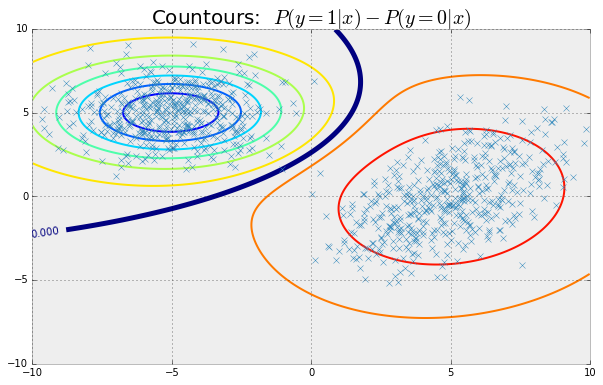

In [4]:
means = [ [-5,5], [5, 0] ]; covs = [ [[3, 0], [0, 2]], [[4, 2], [2, 4]] ]; # define gaussians
plot_decision_contours(means, covs);

### Gaussian Discriminant Analysis: Linear Discriminant Analysis

- We have just showed
    $$
    \log P(\vx|y=c)P(y=c) = - 0.5 \log |\Sigma_c| - 0.5 (\vx-\mu_c)^T \Sigma_c^{-1} (\vx-\mu_c) + \log \pi_c
    $$
    so
    $$
    \begin{split}
    P(y=c|\vx) 
    & \propto P(\vx|y=c)P(y=c) \\
    &= \pi_c |\Sigma_c|^{-0.5} \exp \left[ -0.5 \vx^T \Sigma_c^{-1}\vx + \mu_c^T \Sigma_c^{-1}\vx - 0.5 \mu_c^T \Sigma_c^{-1} \mu_c \right]
    \end{split}
    $$

- When **covariance matrices are shared**, i.e. $\Sigma_c = \Sigma, \forall c = 1,\dots,C$
    $$
    P(y=c|\vx) \propto \boxed{ \exp \left[ \mu_c^T \Sigma^{-1}\vx - 0.5 \mu_c^T \Sigma^{-1} \mu_c + \log \pi_c \right] }
    $$
    We dropped some terms because they don't depend on $c$
    
- Particularly, **softmax function** will show up here
    $$
    P(y=c|\vx) = \frac{\exp \left[ \mu_c^T \Sigma^{-1}\vx - 0.5 \mu_c^T \Sigma^{-1} \mu_c + \log \pi_c \right]}{\sum_{c'=1}^{C} \exp \left[ \mu_{c'}^T \Sigma^{-1}\vx - 0.5 \mu_{c'}^T \Sigma^{-1} \mu_{c'} + \log \pi_{c'} \right]}
    = \frac{\exp \left[\beta_c^T \vx + \gamma_c \right] } {\exp \left[ \sum_{c'=1}^{C} \beta_{c'}^T \vx + \gamma_{c'} \right] }
    $$
    of which $\beta_c = \mu_c^T \Sigma^{-1}$ and $\gamma_{c'}= - 0.5 \mu_c^T \Sigma^{-1} \mu_c + \log \pi_c$

### Gaussian Discriminant Analysis: Linear Discriminant Analysis

- For binary classification with shared covariance matrix, we will get a **linear classifier**
    
    - Consider two class $c=1$ and $c=0$, we could classify using log-odds
    $$
    \log \frac{P(y=1|\vx)}{P(y=0|\vx)} \overset{c=0}{\underset{c=1}{\lessgtr}}  0
    $$
    since $P(y=c|\vx) \propto \exp \left[ \mu_c^T \Sigma^{-1}\vx - 0.5 \mu_c^T \Sigma^{-1} \mu_c + \log \pi_c \right]$, the log-odds criterion could be transformed into
    $$
    (\mu_1-\mu_0)^T \Sigma^{-1} \vx + \left[ \log \frac{\pi_1}{\pi_0} - 0.5 \mu_1^T \Sigma^{-1} \mu_1 + 0.5 \mu_0^T \Sigma^{-1} \mu_0 \right] \overset{c=0}{\underset{c=1}{\lessgtr}}  0
    $$
    
    - Log-odds criterion is finally transformed into determining the sign of liear function, which is quite similar to **Logistic Regression**
    
- When covariance $\Sigma$ is *identity matrix*, the decision boundary becomes
    $$
    (\mu_1-\mu_0)^T \vx + \left[ \log \frac{\pi_1}{\pi_0} - 0.5 \norm{\mu_1} + 0.5 \norm{\mu_0} \right]
    $$
    which is *perpendicular* to line connecting two centroids $\mu_1$ and $\mu_0$ of class $c=1$ and $c=0$.       

### Gaussian Discriminant Analysis: Linear Discriminant Analysis

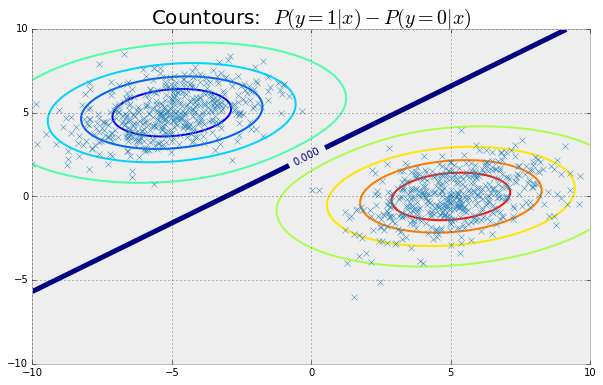

In [3]:
means = [ [-5,5], [5, 0] ]; covs = [ [[3, 1], [1, 2]],[[3, 1], [1, 2]] ]; # define gaussians
plot_decision_contours(means, covs);

### Gaussian Discriminant Analysis:  Parameter Estimation

- One thing we haven't mention is **estimation of parameters $\pi, \mu$ and $\Sigma$

- Using **maximum likelihood estimation** similar to derivation in Naive Bayes, for training data $\mathcal{D} = \{ (\vx_n, y_n) \}_{n=1}^N$ we could get
    $$
    \hat{\pi}_c = \frac{N_c}{N}
    \qquad
    \hat{\mu}_c = \frac{1}{N_c} \sum_{n=1}^N \vx_n \I(y_n=c)
    \qquad
    \hat{\Sigma}_c = \frac{1}{N_c} \sum_{n=1}^N  (\vx_n - \hat{\mu}_c)(\vx_n - \hat{\mu}_c)^T \I(y_n=c)
    $$
    - $N = $ Number of examples in $\mathcal{D}$
    - $N_c = $ Number of examples in class $c$ in $\mathcal{D}$

- Left as an exercise!

> **Remark**
> - Derivation of maximum likelihood estimator

>     - The likelihood is
        $$
        \begin{split}
        P(\mathcal{D}|\pi, \mu, \Sigma)
        &= \prod \nolimits_{n=1}^N P((\vx_n, y_n)|\pi, \mu, \Sigma) = \prod \nolimits_{n=1}^N P(y_n) P(\vx_n|y_n) \\
        &= \prod \nolimits_{n=1}^N \pi_{y_n} (2\pi)^{-D/2} |\Sigma_{y_n}|^{-1/2} \exp \left[ -0.5 (\vx_n-\mu_{y_n})^T \Sigma_{y_n}^{-1} (\vx_n-\mu_{y_n}) \right] \\
        & = \prod \nolimits_{n=1}^N \prod \nolimits_{c=1}^C \left\{ \pi_c (2\pi)^{-D/2} |\Sigma_c|^{-1/2} \exp \left[ -0.5 (\vx_n-\mu_c)^T \Sigma_c^{-1} (\vx_n- \mu_c) \right] \right\}^{\I(y_n=c)} \\    
        \end{split}
        $$
        
>     - Log-likelihood is
        $$
        \begin{split}
        \log P(\mathcal{D}|\pi, \mu, \Sigma) 
        & = \sum \nolimits_{n=1}^N \sum \nolimits_{c=1}^C \I(y_n=c) \log \pi_c - 0.5\sum \nolimits_{n=1}^N \sum \nolimits_{c=1}^C \I(y_n=c) \log|\Sigma_c| \\
        & - 0.5\sum \nolimits_{n=1}^N \sum \nolimits_{c=1}^C \I(y_n=c)(\vx_n-\mu_c)^T \Sigma_c^{-1} (\vx_n- \mu_c)
        \end{split}
        $$       

> - To derive $\hat{\pi}_c$, we have the following problem
    $$
    \begin{matrix}
    \left\{
    \begin{split}
    \max \quad &\log P(\mathcal{D}|\pi, \mu, \Sigma)  \\
    \text{s.t.}  \quad &\sum \nolimits_{c=1}^C \pi_c=1
    \end{split} \right.
    &
    \overset{\text{equivalent to}}{\Longrightarrow}
    &
    \left \{
    \begin{split}
    \max \quad & \sum \nolimits_{n=1}^N \sum \nolimits_{c=1}^C \I(y_n=c) \log \pi_c \\
    \text{s.t.} \quad &\sum \nolimits_{c=1}^C \pi_c = 1
    \end{split}
    \right.
    \end{matrix}
    $$
    Following the derivation in Naive Bayes, we could have
    $$
    \hat{\pi}_c = \frac{\sum \nolimits_{n=1}^N \I(y_n=c)}{ \sum \nolimits_{n=1}^N \sum \nolimits_{c=1}^C \I(y_n=c)} = \frac{N_c}{N}
    $$

> - Derivation of $\hat{\mu}_c$
    $$
    \begin{split}
    \hat{\mu}_c 
    &= \underset{\mu_c}{ \arg \min } \sum \nolimits_{n=1}^N \sum \nolimits_{c=1}^C \I(y_n=c)(\vx_n-\mu_c)^T \Sigma_c^{-1} (\vx_n- \mu_c) \\
    &= \underset{\mu_c}{ \arg \min } \underbrace{ \sum \nolimits_{n=1}^N \I(y_n=c)(\vx_n-\mu_c)^T \Sigma_c^{-1} (\vx_n- \mu_c) }_{L_1}
    \end{split}
    $$
    It's derivative is
    $$
    \begin{split}
    \d L_1 / \d \mu_c
    &= \sum \nolimits_{n=1}^N \I(y_n = c) \left[ 2\Sigma^{-1} (\vx_n - \mu_c) \right] \\
    &= 2 \Sigma^{-1} \sum \nolimits_{n=1}^N \I(y_n = c) (\vx_n - \mu_c)
    \end{split}
    $$
    Setting $\partial L_1 / \partial \mu_c = 0$, we could have
    $$
    \hat{\mu}_c = \frac{\sum \nolimits_{n=1}^N \I(y_n = c) \vx_n }{\sum \nolimits_{n=1}^N  \I(y_n = c)} = \frac{1}{N_c} \sum_{n=1}^N  \I(y_n=c) \vx_n
    $$

> - Derivation of $\hat{\Sigma}_c$
    $$
    \begin{split}
    \hat{\Sigma}_c 
    &= \underset{\Sigma_c}{\arg \min} \sum \nolimits_{n=1}^N \sum \nolimits_{c=1}^C \I(y_n=c) \log|\Sigma_c| + \sum \nolimits_{n=1}^N \sum \nolimits_{c=1}^C \I(y_n=c)(\vx_n-\mu_c)^T \Sigma_c^{-1} (\vx_n- \mu_c) \\
    &= \underset{\Sigma_c}{\arg \min} \sum \nolimits_{n=1}^N \I(y_n=c) \log|\Sigma_c| + \sum \nolimits_{n=1}^N \I(y_n=c)(\vx_n-\mu_c)^T \Sigma_c^{-1} (\vx_n- \mu_c) \\
    &= \underset{\Sigma_c}{\arg \min} \log|\Sigma_c| \sum \nolimits_{n=1}^N \I(y_n=c)  + \sum \nolimits_{n=1}^N \I(y_n=c) \text{trace} \left[ (\vx_n-\mu_c)^T \Sigma_c^{-1} (\vx_n- \mu_c) \right]\\
    &= \underset{\Sigma_c}{\arg \min} \log|\Sigma_c| \sum \nolimits_{n=1}^N \I(y_n=c)  + \sum \nolimits_{n=1}^N \I(y_n=c) \text{trace} \left[ (\Sigma_c^{-1} \vx_n-\mu_c)  (\vx_n- \mu_c)^T \right]\\
    &= \underset{\Sigma_c}{\arg \min} \underbrace{- \log|\Sigma_c^{-1}| \sum \nolimits_{n=1}^N \I(y_n=c)  +  \text{trace} \left[ \Sigma_c^{-1} \sum \nolimits_{n=1}^N \I(y_n=c) (\vx_n-\mu_c) (\vx_n-\mu_c)^T \right] }_{L_2}\\
    \end{split}
    $$
    The derivative with respect to $\Sigma_c^{-1}$ is
    $$
    \d L_2 / \d \Sigma_c^{-1} = - \Sigma_c \sum \nolimits_{n=1}^N \I(y_n=c) + \sum \nolimits_{n=1}^N \I(y_n=c) (\vx_n-\mu_c)  (\vx_n-\mu_c) ^T   
    $$
    Setting $\d L_2 / \d \Sigma_c^{-1}=0$, we could have
    $$
    \hat{\Sigma} = \frac{\sum \nolimits_{n=1}^N \I(y_n=c) (\vx_n-\hat{\mu}_c) (\vx_n-\hat{\mu}_c)^T }{ \sum \nolimits_{n=1}^N \I(y_n=c) } = \frac{1}{N_c} \sum \nolimits_{n=1}^N \I(y_n=c) (\vx_n - \hat{\mu}_c)(\vx_n - \hat{\mu}_c)^T 
    $$

> - We used the fact 
    $$
    \d \text{ trace} (AX)/ \d X = A^T \qquad \d \log |X|/\d X = (X^{-1})^T
    $$

### GDA vs. Logistic Regression

- For a $D$-dimensional feature space, 
    - Logistic Regression must fit $D$ parameters.
    - Gaussian Discriminant Analysis has to fit 
        - $C \cdot D$ parameters for each class mean $\mu_c$
        - $D(D+1)/2$ params for the shared covariance mtx
    - Logistic regression has fewer parameters and is more flexible about data distribution!
    - GDA makes stronger modeling assumptions, and works better (only) when assumptions hold (**approximately**)

## Fisher's Linear Discriminant

- For **binary** classification

### Fisher's Linear Discriminant

- Use $\mathbf{w}$ to project $x$ onto one dimension
    - If projection $\mathbf{w}^T \vx \geq -w_0$ then assign $\mathbf{x}$ to class 1, else to class 0.

- Select a projection $\vw$ that best "separates" the classes, i.e., both
    - Maximizes inter-class separation (distance between means)
    - Minimizes in-class variance
- **Left**: Maximizing inter-class separation alone
- **Right**: Maximizing both inter-class separation and minimizing in-class variance
<center>
<div class="container-fluid">
<div class="row" style="width=100%">
  <div class="col-md-6"><img src="images/separation_alone.png"  style="float: center width:374px; height:288px"></div>
  <div class="col-md-6"><img src="images/separation_and_variance.png" style="float: center; width:374px; height:288px;"></div>
</div>
</div>
</center>

### Fisher's Linear Discriminant:  Objective

- **Goal 1:**  Maximize the *distance* between *projected* means $m_1$ and $m_0$ of two classes
    $$
    \begin{gather}
    \text{maximize}
    \quad
    m_1 - m_0 
    \equiv w^T (\vec{m}_1 - \vec{m}_0) \\
    \vec{m}_1 = \frac{1}{N_1} \sum \nolimits_{i: y_i = 1} x_i \qquad \vec{m}_0 = \frac{1}{N_0} \sum \nolimits_{i: y_i = 0} x_i 
    \end{gather}
    $$

- **Goal 2:**  Minimize the *variance within classes*
    $$
    \text{minimize}
    \quad
    s_1^2 + s_0^2
    \equiv 
    \sum \nolimits_{i: y_i = 1} (\vec{w}^T \vec{x}_i - m_1)^2 + 
    \sum \nolimits_{i: y_i = 0} (\vec{w}^T \vec{x}_i - m_0)^2
    $$
    
- **Objective Function:** Encodes both *Goal 1* and *Goal 2*:
    $$
    \begin{split}
    \text{maximize} \quad J(\vec{w}) 
    &= \frac{(m_1-m_0)^2}{s_1^2 + s_0^2} = \frac{\vec{w}^T (\vec{m}_1 - \vec{m}_0) (\vec{m}_1 - \vec{m}_0)^T \vec{w}}{s_1^2 + s_0^2} = \frac{\vec{w}^T S_B \vec{w}}{s_1^2 + s_0^2}
    \end{split}
    $$
    of which $S_B = (\vec{m}_1 - \vec{m}_0) (\vec{m}_1 - \vec{m}_0)^T$ is the **between-class scatter matrix**
    
- $S_B$ tells us
    - tells us how much the means of different features covary, or
    - how correlated they are (without regard for scaling)

### Fisher's Linear Discriminant:  Objective

- Define the **within-class scatter matrix**
    $$
    S_W = \sum_{i : y_i = 1} (x_i - \vec{m}_1) (x_i - \vec{m}_1)^T +
          \sum_{i : y_i = 0} (x_i - \vec{m}_0) (x_i - \vec{m}_0)^T 
    $$

- As an exercise, check that
    $$
    s_1^2 + s_0^2 = \vec{w}^T S_W \vec{w}
    $$
    
- We can know rewrite the objective explicitly in terms of $\vw$,
    $$
    \text{maximize} \quad J(\vec{w}) = \frac{(m_1-m_0)^2}{s_1^2 + s_0^2} = \frac{\vec{w}^T S_B \vec{w}}{\vec{w}^T S_W \vec{w}}
    $$
    
- The solution $\vec{w} = S_W^{-1} ( \vec{m}_1 - \vec{m}_0 )$. Derivation is in the notes.

> **Remark**
> - Derivation of $\vec{w}$

>     - The derivative of $J(\vw)$ is
        $$
        \frac{\d J(\vw)}{\d \vw} = \frac{\d}{\d \vw} \left( \vw^T S_B \vw \cdot \frac{1}{\vw^T S_W \vw } \right)
        = - \frac{\vw^T S_B \vw}{(\vw^T S_W \vw)^2} S_W \vw + \frac{S_B \vw}{\vw^T S_W \vw}
        $$

>     - Setting $\frac{\d J(\vw)}{\d \vw}=0$, we could have
        $$
        (\vw^T S_B \vw) S_W \vw =(\vw^T S_W \vw) S_B \vw
        $$
        Since we only care the direction of $\vw$ and don't care its magnitude, so this equation can be reduced to
        $$ 
        S_W \vw = S_B \vw
        $$
        Since $S_B \vw = (\vm_1 - \vm_0) (\vm_1 - \vm_0)^T \vw$ and $(\vm_1 - \vm_0)^T \vw$ is a scalar, we could see $S_B \vw $ has direction $\vm_1 - \vm_0$.
        Recall we only care the direction of $\vw$, so we could further write the equation as
        $$
        S_W \vw = \vm_1 - \vm_0
        $$
        and the result is
        $$
        \vw = (S_W)^{-1} (\vm_1 - \vm_0)
        $$